# Image Classification

## System Information

In [1]:
%%bash
lsb_release -a
lscpu
free -g
echo "Memory is in GB!"

Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.5 LTS
Release:	18.04
Codename:	bionic
Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               63
Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz
Stepping:            0
CPU MHz:             2299.998
BogoMIPS:            4599.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            46080K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic 

No LSB modules are available.


## Pip & Imports

In [2]:
%%bash
pip install kaggle
pip install loguru
pip install tqdm

In [3]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
  
import os
from loguru import logger
from tqdm import tqdm
from IPython import display
from google.colab import drive
from concurrent.futures import (ProcessPoolExecutor,
                                ThreadPoolExecutor,
                                as_completed)
import PIL
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

## Download Dataset from Kaggle
1. Go to your Kaggle account and create API Token
2. Upload Kaggle.json to Google Drive
3. Moun the Drive
4. Set environment variable
5. Downloading dataset from https://www.kaggle.com/rhammell/ships-in-satellite-imagery

In [4]:
drive.mount('/content/gdrive')
os.environ['KAGGLE_CONFIG_DIR'] = '/content/gdrive/MyDrive/Kaggle'
logger.info("Kaggle Environment has been set successfully!")

2021-03-30 07:08:17.357 | INFO     | __main__:<module>:3 - Kaggle Environment has been set successfully!


Mounted at /content/gdrive


In [5]:
%%bash
kaggle datasets download -d rhammell/ships-in-satellite-imagery
unzip -q ships-in-satellite-imagery.zip && rm ships-in-satellite-imagery.zip
rm -r scenes && rm shipsnet.json

100%|##########| 185M/185M [00:01<00:00, 110MB/s] 


## Setup TPU Strategy

In [6]:
# Detect hardware
try:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu_address) # TPU detection
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu) 
  # Going back and forth between TPU and host is expensive.
  # Better to run 128 batches on the TPU before reporting back.
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
  print("Number of accelerators: ", strategy.num_replicas_in_sync)
except ValueError:
  print('TPU failed to initialize.')

INFO:tensorflow:Initializing the TPU system: grpc://10.54.24.202:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.54.24.202:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU  ['10.54.24.202:8470']
Number of accelerators:  8


## Load & Prepare Dataset

In [7]:
# BATCH_SIZE is size of batch for each accelator of TPU
# GLOBAL_BATCH_SIZE is size of overall data being processed
# in parallel
BATCH_SIZE = 16
# GLOBAL_BATCH_SIZE = 16 * 8 -> in case of 8 replicas
GLOBAL_BATCH_SIZE = BATCH_SIZE * strategy.num_replicas_in_sync
BUFFER_SIZE = 500
# use tf.data.experimental.AUTOTUNE as it automatically
# chooses the best number of set AUTO = -1
AUTO = tf.data.experimental.AUTOTUNE

In [8]:
def read_image(img_path):
  # tensorflow built-in read_file() wouldn't work because
  # TPU is located on remote server and that wouldn't be
  # able to locate files on local system of colab
  img = PIL.Image.open(img_path)
  img = np.asarray(img, dtype=np.float32)
  img /= 255.0
  return img

In [9]:
# It'll be used as a layer after Input layer and before Conv2d
# or Dense whatever
# Don't use with dataset.map()
with strategy.scope():
  image_augmentator = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    ]
  )

**ThreadPoolExecutor and ProcessPoolExecutor performance is worse than simple!**

```
%%time
with ThreadPoolExecutor(max_workers=4) as executor:
  future_to_files = [executor.submit(read_image, file) for file in non_ship_files]
  non_ship_images = [future.result() for future in as_completed(future_to_files)]
```



In [10]:
%%time
# reading dataset file 0_*.png (non-ship) and 1_*.png (ship)
non_ship_files = tf.io.gfile.glob('shipsnet/shipsnet/0_*.png')
ship_files = tf.io.gfile.glob('shipsnet/shipsnet/1_*.png')
non_ship_images = [read_image(file) for file in non_ship_files]
ship_images = [read_image(file) for file in ship_files]

non_ship_labels = list(np.zeros(shape=(len(non_ship_files), 1)))
ship_labels = list(np.ones(shape=(len(ship_files), 1)))
print(f"length of non-ship images: {len(non_ship_files)}")
print(f"length of ship images: {len(ship_files)}")

length of non-ship images: 3000
length of ship images: 1000
CPU times: user 2.19 s, sys: 284 ms, total: 2.47 s
Wall time: 2.47 s


In [11]:
# combine image urls and labels
# non_ship_data = list(map(lambda image, label: (image, label),non_ship_files, non_ship_label))
# ship_data = list(map(lambda image, label: (image, label), ship_files, ship_label))

# randomly shuffled to avoid data mismatch regarding scene types
np.random.shuffle(non_ship_files)
np.random.shuffle(ship_files)


# created train:dev -> 70:30 split
TRAIN_SPLIT = 0.7

train_images = non_ship_images[:int(len(non_ship_images)*TRAIN_SPLIT)]
train_images.extend(ship_images[:int(len(ship_images)*TRAIN_SPLIT)])
train_labels = non_ship_labels[:int(len(non_ship_labels)*TRAIN_SPLIT)]
train_labels.extend(ship_labels[:int(len(ship_labels)*TRAIN_SPLIT)])
assert len(train_images) == len(train_labels)

dev_images = non_ship_images[int(len(non_ship_images)*TRAIN_SPLIT):]
dev_images.extend(ship_images[int(len(ship_images)*TRAIN_SPLIT):])
dev_labels = non_ship_labels[int(len(non_ship_labels)*TRAIN_SPLIT):]
dev_labels.extend(ship_labels[int(len(ship_labels)*TRAIN_SPLIT):])
assert len(dev_images) == len(dev_labels)

print(f"train set size: {len(train_images)}")
print(f"dev set size: {len(dev_images)}")

train set size: 2800
dev set size: 1200


In [12]:
def load_train_dataset():
  dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
  # Don't use tf.io.____ because TPU is hosted remotely and
  # don't have access to this system
  # dataset = dataset.map(read_image, num_parallel_calls=8)
  # Don't use image_augmentation here it will throw an error
  # dataset = dataset.map(image_augmentation, num_parallel_calls=8)
  # if we use small buffer size than len(train_images) it will load
  # some batches that may contain only one class labels.
  dataset = dataset.shuffle(len(train_images))
  dataset = dataset.batch(GLOBAL_BATCH_SIZE, drop_remainder=True)
  dataset = dataset.prefetch(AUTO)
  return dataset

In [13]:
def load_dev_dataset():
  dataset = tf.data.Dataset.from_tensor_slices((dev_images, dev_labels))
  dataset = dataset.batch(GLOBAL_BATCH_SIZE, drop_remainder=True)
  dataset = dataset.prefetch(AUTO)
  return dataset

In [14]:
with strategy.scope():
  train_dataset = load_train_dataset()
  dev_dataset = load_dev_dataset()

## Visualize Data

In [15]:
def get_random_N_from_dataset(dataset, N):
  """
  Get train or dev examples

  dataset: train_dataset or dev_dataset
  N: no of examples to extract
  """
  dataset = dataset.shuffle(BUFFER_SIZE).unbatch().batch(N)
  if tf.executing_eagerly():
    for images, labels in dataset:
      images = images.numpy()
      labels = labels.numpy()
      break
  
  return images, labels

In [16]:
def visualize_images(images, labels, n_cols=3):
  """
  visualize images from train or dev set
  """
  n_cols = n_cols or len(images)
  n_rows = (len(images) - 1) // n_cols + 1

  plt.figure(figsize=(n_cols*3, n_rows*3))

  for index, (image, label) in enumerate(zip(images, labels)):
    ax = plt.subplot(n_rows, n_cols, index + 1)
    plt.imshow(image)
    plt.axis('off')
    if label == 0:
      label, color = 'non-ship', 'red'
    elif label == 1:
      label, color = 'ship', 'green'
    ax.text(30, 90, label, color=color)
    

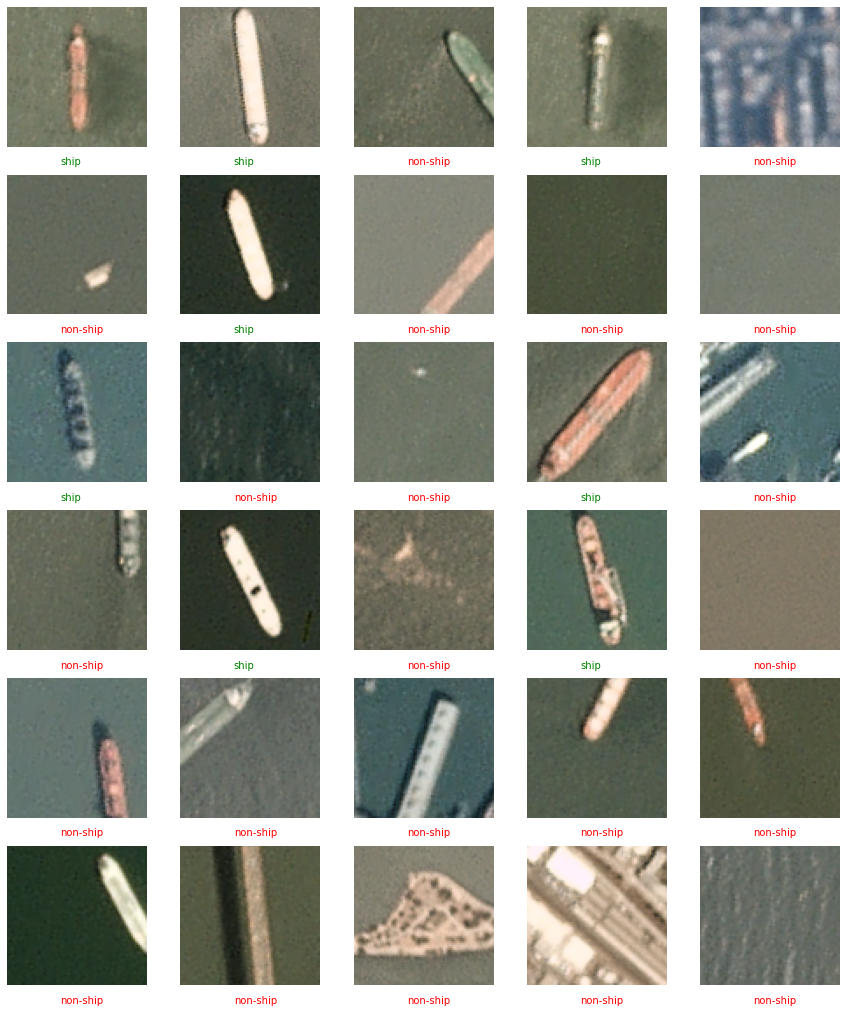

In [17]:
# visualize train_dataset or dev_dataset
images, labels = get_random_N_from_dataset(train_dataset, N=30)
visualize_images(images, labels, n_cols=5)

## ResNet Model

In [18]:
class IdentityBlock(tf.keras.layers.Layer):
  def __init__(self, filters, kernel_size, skip_layers):
    super(IdentityBlock, self).__init__()
    # usually 2 layers are skipped, however 3 can also be skipped
    # we made it dynamic to skip as many layers required
    self.skip_layers = skip_layers
    self.conv2d = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
    self.batch_norm = tf.keras.layers.BatchNormalization()
    self.activation = tf.keras.layers.Activation('relu')
    self.add = tf.keras.layers.Add()
  
  def call(self, input_tensor):
    # self.num_layer is no of skip connection layers
    for i in range(self.skip_layers-1):
      x = self.conv2d(input_tensor)
      x = self.batch_norm(x)
      x = self.activation(x)
    
    x = self.conv2d(x)
    x = self.batch_norm(x)

    x = self.add([x, input_tensor])
    x = self.activation(x)
    return x

In [19]:
# Test only
with strategy.scope():
  iblock = IdentityBlock(64, 3, 2)
out = iblock(np.arange(1*32*32*64, dtype=np.float32).reshape(1, 32, 32, 64))
print(out.shape)

(1, 32, 32, 64)


In [20]:
class ResNet(tf.keras.Model):
  def __init__(self, image_augumentation=None, num_output=1, output_activation='sigmoid', skip_layers=2):
    super(ResNet, self).__init__()
    self.image_augumentation = image_augumentation
    self.conv2d = tf.keras.layers.Conv2D(64, 7, padding='same')
    self.batch_norm = tf.keras.layers.BatchNormalization()
    self.activation = tf.keras.layers.Activation('relu')
    # stride for max pooling is not specified so it will be (3, 3)
    # same as pool window size
    self.max_pool_2d = tf.keras.layers.MaxPooling2D((3, 3))

    self.idb1 = IdentityBlock(64, 3, skip_layers)
    self.idb2 = IdentityBlock(64, 3, skip_layers)

    self.global_pool_2d = tf.keras.layers.GlobalAveragePooling2D()
    self.classifier = tf.keras.layers.Dense(num_output, activation=output_activation)
  
  def call(self, input_tensor):
    if self.image_augumentation:
      x = self.image_augumentation(input_tensor)
    # input_tensor -> (batch, 80, 80, 3)
    x = self.conv2d(input_tensor)
    # x -> (batch, 80, 80, 64)
    x = self.batch_norm(x)
    x = self.activation(x)
    x = self.max_pool_2d(x)
    # x -> (batch, 26, 26, 64)

    x = self.idb1(x)
    # x -> (batch, 26, 26, 64)
    x = self.idb2(x)
    # x -> (batch, 26, 26, 64)

    x = self.global_pool_2d(x)
    # x -> (batch, 26, 26)
    return self.classifier(x)

In [21]:
# Test only
x = tf.random.uniform(shape=(32, 80, 80, 3))
with strategy.scope():
  model = ResNet(image_augumentation=image_augmentator)
out = model(x)
print(out.shape)

(32, 1)


## Define Metrics

In [22]:
class F1Score(tf.keras.metrics.Metric):

  def __init__(self, name='f1_score', **kwargs):
    super(F1Score, self).__init__(name=name, **kwargs)

    # true positive
    self.tp = tf.Variable(0, dtype=tf.int32)
    # false positive
    self.fp = tf.Variable(0, dtype=tf.int32)
    # true negative
    self.tn = tf.Variable(0, dtype=tf.int32)
    # false negative
    self.fn = tf.Variable(0, dtype=tf.int32)

  def update_state(self, y_true, y_pred):
    '''
    Update states of metrics
    '''
    # y_pred contains logits range [0, 1]
    y_pred = tf.where(y_pred >= 0.5, 1., 0.)
    # squeeze y_pred (remove extra dimension)
    y_pred = tf.squeeze(y_pred)
    # squeeze y_true
    y_true = tf.squeeze(y_true)

    # compute confusion matrix
    confusion_matrix = tf.math.confusion_matrix(y_true, y_pred, num_classes=2)

    # update tp, fp, tn, fn
    # https://www.dataschool.io/content/images/2015/01/confusion_matrix2.png
    # This link provides the exact way of intrepreting confusion matrix
    self.tn.assign_add(confusion_matrix[0][0])
    self.fp.assign_add(confusion_matrix[0][1])
    self.fn.assign_add(confusion_matrix[1][0])
    self.tp.assign_add(confusion_matrix[1][1])

  def result(self):
    '''
    Compute metrics and returns its value
    '''
    # Calculate precision
    if (self.tp + self.fp == 0):
      precision = 1.0
    else:
      precision = self.tp / (self.tp + self.fp)
      
    # Calculate recall
    if (self.tp + self.fn == 0):
      recall = 1.0
    else:
      recall = self.tp / (self.tp + self.fn)

    # Return F1 Score
    f1_score = 2 * ((precision * recall) / (precision + recall))
    return f1_score
  
  def reset_states(self):
    '''
    Reset metrices
    '''
    self.tn.assign_add(0)
    self.fp.assign_add(0)
    self.fn.assign_add(0)
    self.tp.assign_add(0)


In [23]:
with strategy.scope():
  # Define f1-score metric for train and dev
  train_f1score_metric = F1Score(name='train_f1_score')
  dev_f1score_metric = F1Score(name='dev_f1_score')

  # Define binary accuracy metric for train and dev
  train_acc_metric = tf.keras.metrics.BinaryAccuracy(name='train_acc', dtype=tf.float32)
  dev_acc_metric = tf.keras.metrics.BinaryAccuracy(name='dev_acc', dtype=tf.float32)


## Training

In [26]:
# Define optimizer
with strategy.scope():
  optimizer = tf.keras.optimizers.Adam()

In [28]:
with strategy.scope():
  # define model
  model = ResNet()

  loss_object = tf.keras.losses.BinaryCrossentropy(
      reduction=tf.keras.losses.Reduction.NONE
  )

  def compute_loss(y_true, y_pred):
    per_example_loss = loss_object(y_true, y_pred)
    # compute average loss across all replicas (accelerators) ~ 8 in our case
    return tf.nn.compute_average_loss(per_example_loss,
                                      global_batch_size=GLOBAL_BATCH_SIZE)
  
  @tf.function
  def distributed_train_step(images, labels):
    per_replica_losses = strategy.run(train_step, args=(images, labels,))
    # it will sum loss for each replica and that's how a full
    # batch of 64 e.g is executed by 8 replicas(copies of model)
    # in our case where each replica processes only a batch of 8
    # examples
    return strategy.reduce(tf.distribute.ReduceOp.SUM,
                           per_replica_losses,
                           axis=None)

  @tf.function
  def distributed_dev_step(images, labels):
    per_replica_losses = strategy.run(dev_step, args=(images, labels,))
    return strategy.reduce(tf.distribute.ReduceOp.SUM,
                           per_replica_losses,
                           axis=None)

  
  def train_step(images, labels):
    with tf.GradientTape() as tape:
       predictions = model(images)
       loss = compute_loss(labels, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
       
    train_acc_metric.update_state(labels, predictions)
    train_f1score_metric.update_state(labels, predictions)
    return loss

  def dev_step(images, labels):
    predictions = model(images)
    loss = compute_loss(labels, predictions)

    dev_acc_metric.update_state(labels, predictions)
    dev_f1score_metric.update_state(labels, predictions)
    return loss

In [29]:
# load train, dev datasets
print("--------------------Loading dataset!--------------------")
with strategy.scope():
  train_dataset = load_train_dataset()
  dev_dataset = load_dev_dataset()
print("----------------Done with loading dataset!-------------------")
display.clear_output(wait=False)

NUM_TRAIN_BATCH = len(train_dataset)
NUM_DEV_BATCH = len(dev_dataset)
EPOCHS = 50

history = {}
history['train_loss_history'] = []
history['dev_loss_history'] = []
history['train_acc_history'] = []
history['dev_acc_history'] = []
history['train_f1score_history'] = []
history['dev_f1score_history'] = []

with strategy.scope():
  for epoch in range(EPOCHS):

    train_loss = 0.0
    num_batches = 0
    train_dataset = train_dataset.shuffle(len(train_images))
    with tqdm(total=NUM_TRAIN_BATCH, desc='train', leave=False) as pbar:
      for images, labels in train_dataset:
        train_loss += distributed_train_step(images, labels)
        num_batches += 1
        pbar.update(1)
    train_loss /= num_batches
    #print(f"batches: {num_batches}")

    dev_loss = 0.0
    num_batches = 0
    dev_dataset = dev_dataset.shuffle(len(dev_images))
    with tqdm(total=NUM_DEV_BATCH, desc='dev', leave=False) as pbar:
      for images, labels in dev_dataset:
        dev_loss += distributed_dev_step(images, labels)
        num_batches += 1
        pbar.update(1)
    dev_loss /= num_batches

    logger.info(f"epoch: {epoch+1},\
    train_loss: {train_loss:.3f},\
    train_acc: {train_acc_metric.result():.4f},\
    train_f1_score: {train_f1score_metric.result():.4f},\
    dev_loss: {dev_loss:.3f},\
    dev_acc: {dev_acc_metric.result():.4f},\
    dev_f1_score: {dev_f1score_metric.result():.4f}"
    )

    # record history
    history['train_loss_history'].append(train_loss.numpy())
    history['dev_loss_history'].append(dev_loss.numpy())
    history['train_acc_history'].append(train_acc_metric.result())
    history['dev_acc_history'].append(dev_acc_metric.result())
    history['train_f1score_history'].append(train_f1score_metric.result())
    history['dev_f1score_history'].append(dev_f1score_metric.result())

    # reset metrices states
    train_acc_metric.reset_states()
    train_f1score_metric.reset_states()
    dev_acc_metric.reset_states()
    dev_f1score_metric.reset_states()

2021-03-30 07:17:28.879 | INFO     | __main__:<module>:45 - epoch: 1,    train_loss: 4.521,    train_acc: 0.7329,    train_f1_score: 0.0865,    dev_loss: 4.186,    dev_acc: 0.7812,    dev_f1_score: 0.0000
2021-03-30 07:17:30.420 | INFO     | __main__:<module>:45 - epoch: 2,    train_loss: 4.422,    train_acc: 0.7533,    train_f1_score: 0.0469,    dev_loss: 4.243,    dev_acc: 0.7812,    dev_f1_score: 0.0000
2021-03-30 07:17:31.861 | INFO     | __main__:<module>:45 - epoch: 3,    train_loss: 4.471,    train_acc: 0.7493,    train_f1_score: 0.0320,    dev_loss: 4.161,    dev_acc: 0.7812,    dev_f1_score: 0.0000
2021-03-30 07:17:33.186 | INFO     | __main__:<module>:45 - epoch: 4,    train_loss: 4.475,    train_acc: 0.7496,    train_f1_score: 0.0243,    dev_loss: 4.193,    dev_acc: 0.7812,    dev_f1_score: 0.0000
2021-03-30 07:17:34.526 | INFO     | __main__:<module>:45 - epoch: 5,    train_loss: 4.445,    train_acc: 0.7496,    train_f1_score: 0.0196,    dev_loss: 4.153,    dev_acc: 0.7812,

## Plot Metrics

In [31]:
def plot_metrics(train_history, dev_history, metric_name):
  assert len(train_history) == len(dev_history)
  ax = plt.figure(figsize=(15, 5))
  plt.plot(train_history, label='train', color='blue')
  plt.plot(dev_history, label='dev', color='green')
  #plt.xticks(list(range(1, len(train_history)+1)))
  plt.legend()
  plt.title(metric_name)
  plt.show()

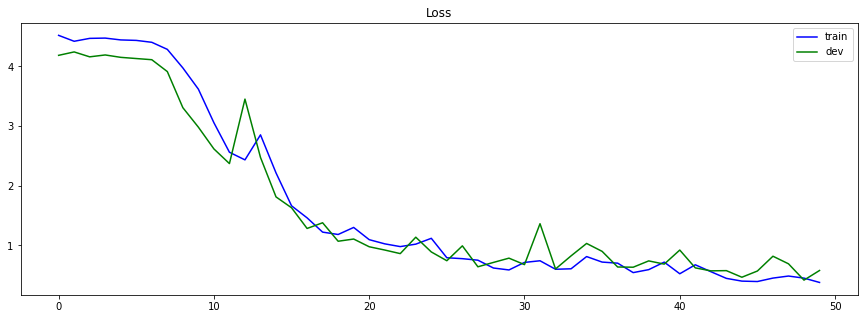

In [32]:
# plot loss
plot_metrics(history['train_loss_history'], history['dev_loss_history'], 'Loss')

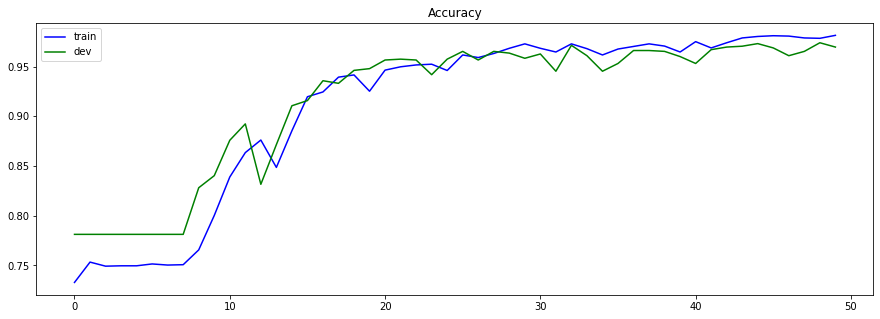

In [33]:
# plot accuracy
plot_metrics(history['train_acc_history'], history['dev_acc_history'], 'Accuracy')

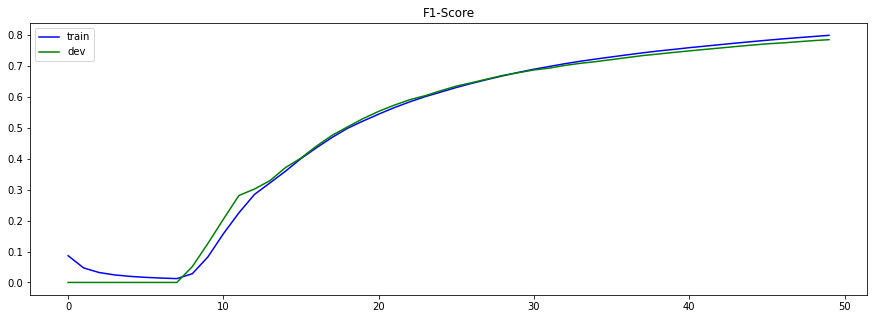

In [35]:
# plot loss
plot_metrics(history['train_f1score_history'], history['dev_f1score_history'], 'F1-Score')

## Inference

In [36]:
with strategy.scope():
  dev_dataset = load_dev_dataset()

# The folowing line of code is convenient way to count examples.
# len(list(dev_dataset.unbatch().batch(30).as_numpy_iterator())[0][1])

In [37]:
def inference_on_N(dataset, N):
  random_N_from_dataset = get_random_N_from_dataset(dataset, N)
  images, labels = random_N_from_dataset
  predictions = model(images)
  predictions = tf.where(predictions >= 0.5, 1., 0.)
  predictions = tf.squeeze(predictions)
  labels = tf.squeeze(labels)
  labels = tf.cast(labels, dtype=tf.float32)
  return images, labels, predictions

In [38]:
N = 30
images, labels, predictions = inference_on_N(dev_dataset, N)
# print(labels)
# print(predictions)

## Visualize Misclassified

In [39]:
def get_missclassified_examples(images, labels, predictions):
  mis_index = tf.math.not_equal(predictions, labels)
  mis_images = images[mis_index, :]
  mis_labels = labels[mis_index].numpy()
  mis_predictions = predictions[mis_index].numpy()
  return mis_images, mis_labels, mis_predictions

In [40]:
def visualize_misclassified(images, labels, predictions, n_cols=3):
  assert len(images) == len(labels) == len(predictions)
  assert len(images) > 0, "Try to re-run the inference on other examples\
  as there are no misclassified examples in it!"

  n_cols = n_cols or len(images)
  n_rows = (len(images) - 1) // n_cols + 1

  plt.figure(figsize=(n_cols*3, n_rows*3))
  plt.subplots_adjust(hspace=0.4, wspace=0.2)

  for index, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    ax = plt.subplot(n_rows, n_cols, index + 1)
    plt.imshow(image)
    plt.axis('off')

    ax.text(5, 90, ' '.join(['Label:', 'ship' if label == 1.0 else 'non-ship']), color='green')
    ax.text(5, 100, ' '.join(['Prediction:', 'ship' if prediction == 1.0 else 'non-ship']), color='red')


In [41]:
mis_images, mis_labels, mis_predictions = get_missclassified_examples(images,
                                                                      labels,
                                                                      predictions)

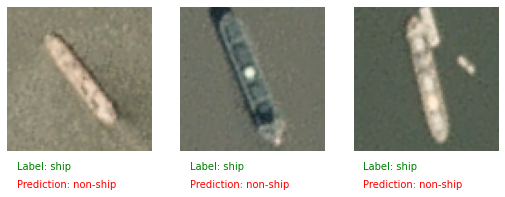

In [42]:
visualize_misclassified(mis_images, mis_labels, mis_predictions, n_cols=5)

# Knowledge Distillation

In [ ]:
data = tf.random.uniform(shape=(32, 30))
dense = tf.keras.layers.Dense(1, activation='sigmoid')
dense(data)

In [ ]:
'''train_dataset = load_train_dataset()'''
'''images, labels = next(train_dataset.take(1).as_numpy_iterator())'''
'''loss_object = tf.keras.losses.BinaryCrossentropy()'''
'''model = ResNet()
opt = tf.keras.optimizers.Adam()
with tf.GradientTape() as tape:
  output = model(images)
  print(output.shape)
  loss = loss_object(output, labels)

gradients = tape.gradient(loss, model.trainable_variables)
opt.apply_gradients(zip(gradients, model.trainable_variables))'''

In [1]:
import tensorflow as tf

In [16]:
class CustomMSE(tf.keras.losses.Loss):
    def __init__(self, *args, **kwargs):
      super(CustomMSE, self).__init__(*args, **kwargs)

    def call(self, y_true, y_pred):
      mse = tf.math.reduce_mean(tf.square(y_true - y_pred))
      return mse

In [17]:
loss_object = CustomMSE(reduction=tf.keras.losses.Reduction.NONE)

In [6]:
x1 = tf.range(1, 10, 1)
x2 = tf.range(100, 1000, 100)

In [18]:
loss_object(x1, x2)

<tf.Tensor: shape=(), dtype=int32, numpy=310365>